In [1]:
# Directories
import os
os.chdir(r"E:\academy\OneDrive - IIT Delhi\3. IIT DELHI\2. Academics\1_PAPER\2_Analysis")
print(os.getcwd())


E:\academy\OneDrive - IIT Delhi\3. IIT DELHI\2. Academics\1_PAPER\2_Analysis


In [2]:
#Array packages
import cartopy.crs as ccrs
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc4
from dask.distributed import Client

from scipy.stats import kendalltau
import pymannkendall as mk

#plots
import matplotlib.pyplot as plt
import rioxarray as rio
import geopandas as gpd
from shapely.geometry import mapping
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator

#Progress meter
from dask.diagnostics import ProgressBar
from tqdm import tqdm

# Directories
import os
import glob
import dask
#import h5netcdf
import scipy


ImportError: cannot import name 'is_namedtuple_instance' from 'dask.utils' (C:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\dask\utils.py)

In [102]:
ds_sliced['TotalPrecip_tavg'].compute()
ds_sliced=ds_sliced.fillna(20).compute()
#interpolated_data['TotalPrecip_tavg'].compute()
ds_sliced['TotalPrecip_tavg'].compute()

<xarray.DataArray 'TotalPrecip_tavg' (year: 42)>
array([ 0.44937003,  3.6691477 ,  3.4529648 ,  1.4320518 , 20.        ,
        3.4117274 ,  1.078117  ,  2.8908942 ,  2.4030826 ,  5.620851  ,
       15.542487  ,  0.9038124 ,  1.0233554 ,  3.1405625 ,  2.893529  ,
        7.4391727 ,  0.46664843,  1.9881873 ,  2.2751777 ,  2.7820752 ,
        7.7157435 ,  3.5258596 ,  1.0721552 ,  2.6971052 ,  5.128602  ,
        2.847582  , 13.566625  ,  3.42181   ,  0.97441554,  4.5789375 ,
        1.9154881 ,  0.577721  ,  0.3567238 ,  1.620155  ,  8.272326  ,
       21.567005  ,  2.9625938 ,  0.81013775,  1.1271214 ,  1.0783465 ,
        4.43677   , 10.525405  ], dtype=float32)
Coordinates:
  * year     (year) int64 1980 1981 1982 1983 1984 ... 2017 2018 2019 2020 2021

In [4]:
mdl=1
ss=2
ssn=['Pre-monsoon','Monsoon','Post-monsoon','Winter']
ssn_m=[[3,4,5],[6,7,8,9],[10,11],[12,1,2]]
model=["LIS_MERRA2","LIS_IMD","LIS_CHIRPS","LIS_ERA5"]

#Readingg data
lsm_M = xr.open_mfdataset(f"DATA_p/{model[mdl]}_1980_2021.nc",engine='netcdf4', parallel=True,chunks={'time': 'auto'})
lsm_M=lsm_M*60*60*24*30 #converting to mm/ month
lsm_M=lsm_M.where(lsm_M>=0) 
lsm_M=lsm_M[['TotalPrecip_tavg','Evap_tavg','Qs_tavg']]

#Seasonalizing 
ds=lsm_M
months=ds["time.month"]
ds=ds.sel(time=months.isin(ssn_m[ss]))
ds=ds.groupby("time.year").mean(dim="time")

#Slicing
#min_lon, max_lon = 73, 78  
min_lon, max_lon = 82, 85
min_lat, max_lat = 20, 23  
ds_sliced = ds.sel(lon=slice(min_lon, max_lon), lat=slice(min_lat, max_lat))

ds_ts=ds_sliced.mean(dim=['lat','lon']).compute()

RE=ds_ts["Qs_tavg"]/ds_ts["TotalPrecip_tavg"]
ds_ts['RE']=RE

ds_ts=ds_ts.where(ds_ts['RE']<1)
ds_ts=ds_ts.interpolate_na(dim="year", method="linear") # filling nan values

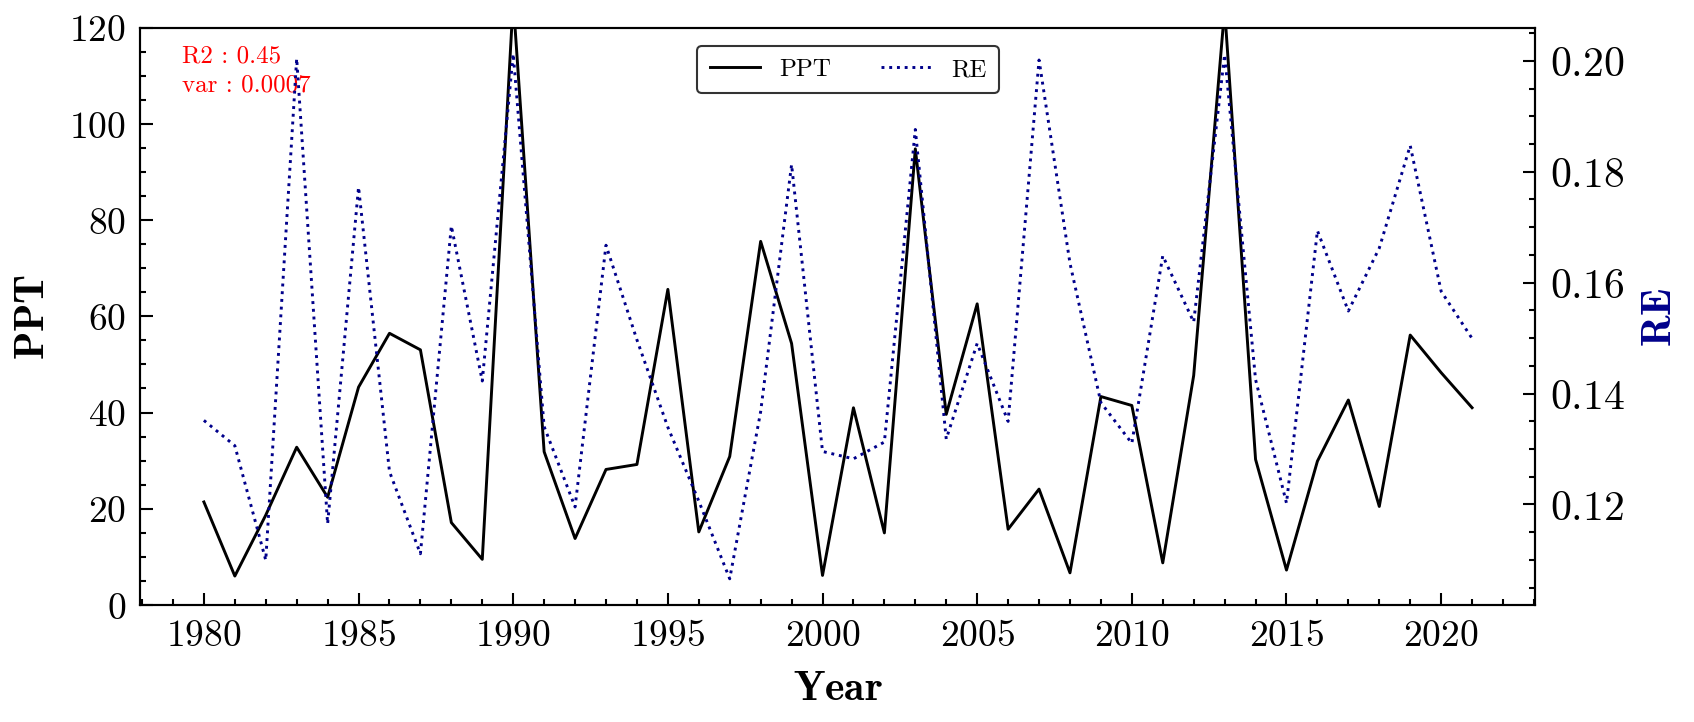

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import scienceplots

plt.style.use(['science','no-latex','bright'])
# Assuming ds_sliced and ds_norm are defined elsewhere

fig, ax1 = plt.subplots(figsize=(6,2.5), facecolor='white', dpi=300)

yr = ds_ts['year']
ppt = ds_ts['TotalPrecip_tavg']
re = ds_ts['RE']
Q=ds_ts['Qs_tavg']

lw = 0.7
al = 1

# Plotting on the primary y-axis (ax1)
ax1.plot(yr, ppt, color='black', label='PPT', alpha=al, linewidth=lw)
ax1.set_xlabel('$\mathbf{Year}$', fontsize=10)
ax1.set_ylabel('$\mathbf{PPT}$', fontsize=10, color='Black')  # Labeling the primary y-axis

# Creating a secondary y-axis
ax2 = ax1.twinx()

# Plotting on the secondary y-axis (ax2)
ax2.plot(yr,re , color='darkblue', label='RE', alpha=al, linewidth=lw,linestyle='dotted')
ax2.set_ylabel('$\mathbf{RE}$', fontsize=10, color='darkblue')  # Labeling the secondary y-axis
#ax2.set_ylim(0.02, 0.08)

# Additional settings
plt.xticks(np.arange(1980, 2020+1, 5.0),fontsize=8)
#ax1.grid(True, color='grey', alpha=0.08)

ax1.set_ylim(0, 120)

# Customizing ticks
ax1.xaxis.set_tick_params(which='both', bottom=True, top=False,labelsize=9)
ax1.yaxis.set_tick_params(which='both', left=True, right=False,labelsize=9)
ax2.yaxis.set_tick_params(which='both', left=False, right=True)

# Adding legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lgnd=ax1.legend(lines + lines2, labels + labels2, loc='upper left', ncol=7, fontsize=6, bbox_to_anchor=(0.39, 0.99),frameon=True, borderpad=0.5, edgecolor='black')
frame = lgnd.get_frame()
frame.set_linewidth(0.5)

c=np.corrcoef(np.array(re),np.array(ppt))
var=np.var(np.array(re))
ax1.text(0.03, 0.97, f"R2 : {c[0,1]:.2f}", fontsize=6, color='red',
     ha='left', va='top', transform=ax1.transAxes)
ax1.text(0.03, 0.92, f"var : {var:.4f}", fontsize=6, color='red',
     ha='left', va='top', transform=ax1.transAxes)

#plt.savefig('region B.png')
plt.show()


### Checks


In [145]:
np.corrcoef(ds1['RE'].sel(lat=25,lon=75,method='nearest').values,ds1['RE'].sel(lat=25,lon=75,method='nearest').values)
ds1['RE'].sel(lat=25,lon=75,method='nearest').values


array([0.        , 0.03275786, 0.07859889, 0.10664283, 0.        ,
       0.10207406, 0.08822043, 0.07875832, 0.06340969, 0.06453841,
       0.08143927, 0.07363455, 0.1001751 , 0.06785227, 0.11056611,
       0.10311447, 0.12365625, 0.0855316 , 0.03443905, 0.0823824 ,
       0.11599173, 0.07419948, 0.02687085, 0.08659615, 0.10705401,
       0.        , 0.        , 0.        , 0.09039894, 0.05746628,
       0.07988335, 0.        , 0.        , 0.10252193, 0.09093744,
       0.        , 0.1140918 , 0.        , 0.        , 0.18716627,
       0.07461739, 0.13951336], dtype=float32)

C:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


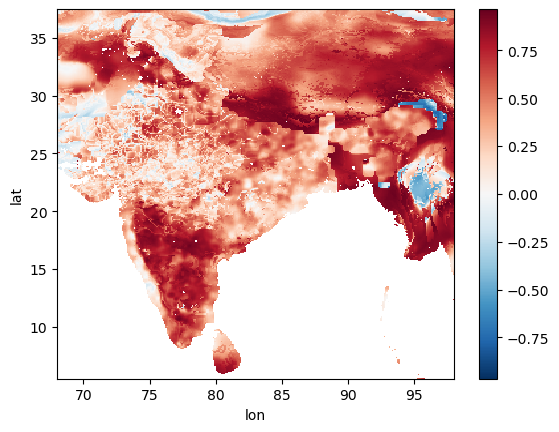

In [25]:
mdl=1
ss=2
reg_lon=[[73,78],[82,85]]
reg_lat=[[20,23],[20,23]]
ssn=['Pre-monsoon','Monsoon','Post-monsoon','Winter']
ssn_m=[[3,4,5],[6,7,8,9],[10,11],[12,1,2]]
model=["LIS_MERRA2","LIS_IMD","LIS_CHIRPS","LIS_ERA5"]

#Readingg data
lsm_M = xr.open_mfdataset(f"DATA_p/{model[mdl]}_1980_2021.nc",engine='netcdf4', parallel=True,chunks={'time': 'auto'})
#lsm_M=lsm_M*60*60*24*30 #converting to mm/ month
lsm_M=lsm_M.where(lsm_M>=0) 
lsm_M=lsm_M[['TotalPrecip_tavg','Evap_tavg','Qs_tavg']]

#Seasonalizing 
ds=lsm_M
months=ds["time.month"]
ds=ds.sel(time=months.isin(ssn_m[1]))
ds=ds.groupby("time.year").mean(dim="time")
RE=ds["Qs_tavg"]/ds["TotalPrecip_tavg"]
ds['RE']=RE
ds=ds.where(ds['RE']<0.7,1)

#Seasonalizing 
ds1=lsm_M
months=ds1["time.month"]
ds1=ds1.sel(time=months.isin(ssn_m[2]))
ds1=ds1.groupby("time.year").mean(dim="time")

RE=ds1["Qs_tavg"]/ds1["TotalPrecip_tavg"]
ds1['RE']=RE
ds1=ds1.where(ds1['RE']<0.7,0)
ds1

xr.corr(ds['TotalPrecip_tavg'], ds1['RE'], dim='year').plot()


In [82]:
reg_lon=[[78,79],[80,83]]
reg_lat=[[11,12],[20,23]]

rg=1
#Seasonalizing 
ds=lsm_M
months=ds["time.month"]
ds=ds.sel(time=months.isin(ssn_m[1]))
ds=ds.groupby("time.year").mean(dim="time")
min_lon, max_lon = reg_lon[rg][0],reg_lon[rg][1]
min_lat, max_lat = reg_lat[rg][0],reg_lat[rg][1]
ds_sliced = ds.sel(lon=slice(min_lon, max_lon), lat=slice(min_lat, max_lat))
ds_ts=ds_sliced.mean(dim=['lat','lon']).compute()
RE=ds_ts["Qs_tavg"]/ds_ts["TotalPrecip_tavg"]
ds_ts['RE']=RE
ds_ts=ds_ts.where(ds_ts['RE']<0.8)
ds_ts=ds_ts.interpolate_na(dim="time", method="linear")

ds=lsm_M
months=ds["time.month"]
ds=ds.sel(time=months.isin(ssn_m[2]))
ds=ds.groupby("time.year").mean(dim="time")
min_lon, max_lon = reg_lon[rg][0],reg_lon[rg][1]
min_lat, max_lat = reg_lat[rg][0],reg_lat[rg][1]
ds_sliced = ds.sel(lon=slice(min_lon, max_lon), lat=slice(min_lat, max_lat))
ds_ts1=ds_sliced.mean(dim=['lat','lon']).compute()
RE=ds_ts1["Qs_tavg"]/ds_ts1["TotalPrecip_tavg"]
ds_ts1['RE']=RE
ds_ts1=ds_ts1.where(ds_ts1['RE']<0.8)
ds_ts1=ds_ts1.interpolate_na(dim="time", method="linear")

In [83]:
import numpy as np
np.corrcoef(ds_ts['TotalPrecip_tavg'].values,ds_ts1['RE'].values)

array([[1.        , 0.40904689],
       [0.40904689, 1.        ]])

In [56]:
ds_ts1['RE'].values
ds_ts['TotalPrecip_tavg']
ds_ts1["TotalPrecip_tavg"]

<xarray.DataArray 'TotalPrecip_tavg' (year: 42)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan], dtype=float32)
Coordinates:
  * year     (year) int32 1980 1981 1982 1983 1984 ... 2017 2018 2019 2020 2021

array([[1.        , 0.25424462],
       [0.25424462, 1.        ]])

In [ ]:
ds_sliced = ds.sel(lon=slice(min_lon, max_lon), lat=slice(min_lat, max_lat))

# Plot latlon info check

In [137]:
ds_ts['RE'].var(dim='year')

<xarray.DataArray 'RE' ()>
array(2.78918797e-05)

C:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\dask\array\numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


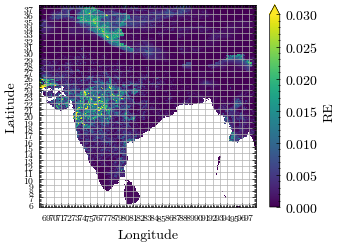

In [138]:
lsm_M = xr.open_mfdataset(f"DATA_p/{model[mdl]}_1980_2021.nc",engine='netcdf4', parallel=True,chunks={'time': 'auto'})
lsm_M=lsm_M*60*60*24*30 #converting to mm/ month
lsm_M=lsm_M.where(lsm_M>=0) 
lsm_M=lsm_M[['TotalPrecip_tavg','Evap_tavg','Qs_tavg']]
RE=lsm_M["Qs_tavg"]/lsm_M["TotalPrecip_tavg"]
RE = RE.where(~np.isinf(RE), other=0)
RE=RE.where(RE<1)
lsm_M['RE']=RE

ds=lsm_M
months=ds["time.month"]
ds=ds.sel(time=months.isin(ssn_m[ss]))
ds=ds.groupby("time.year").mean(dim="time")



ds_re=ds['RE'].var(dim='year')
ds_re.plot(vmin=0,vmax=0.03)

# Customizing latitude and longitude labels and gridlines
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)  # Show gridlines

plt.gca().xaxis.set_major_locator(MultipleLocator(1))  # Adjust as needed
plt.gca().yaxis.set_major_locator(MultipleLocator(1)) 

plt.xticks(fontsize=7)  # Adjust font size of x-axis ticks
plt.yticks(fontsize=7)  # Adjust font size of y-axis ticks

plt.show()